# PRL and Neuroptimal - v. 2

**Select Kernel: hddmpy36 (Python 3.6.10)**

This is the script for the HDDMrl analysis of the PRL data for two groups of patients:

- patients with Neuroptimal treatment,
- patients with sham Neuroptimal treatment. 

Each participant in the treatment group completed 320 trials at time t0 (before the treatment) and 320 trials at time t2 (after the treatment). 

In the present script, the data of time point t1 are ignored. Data for t1 have been collected only for the treatment group.

In [1]:
import datetime
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2022-06-05 18:15:53


# Import packages

In [2]:
#import
import sys
from kabuki.analyze import gelman_rubin
import pandas as pd
import numpy as np
import hddm
print(hddm.__version__)
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import pymc
import kabuki
sns.set(style="ticks", color_codes=True)
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
from tqdm import tqdm # progress tracker
from patsy import dmatrix

/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


0.8.0


In [3]:
print('Notebook is running:', sys.executable)
# further check your python version
from platform import python_version
print('The current Python version is', python_version())
print('The current HDDM version is', hddm.__version__) # 0.8.0

Notebook is running: /opt/anaconda3/envs/hddmpy36/bin/python
The current Python version is 3.6.10
The current HDDM version is 0.8.0


# Analysis with hDDMrl.

In [31]:
# Load data from csv file into a NumPy structured array
data = hddm.load_csv('data/complete_design/input_for_hddmrl_complete_design.csv')

There are 51 participants.


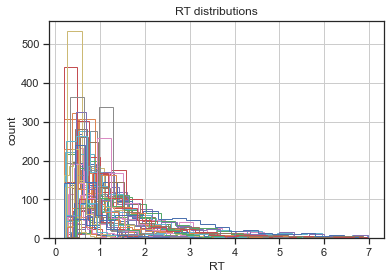

In [32]:
# Uncomment the codes below if you are interested in checking the distribution of raw data
# plot and save the distribution of raw data:
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)
# plt.savefig('plot_hist_rt_patients.pdf')

print('There are %d participants.' %data['subj_idx'].nunique())

The columns in the datafile represent: 

- subj_idx (subject id), 
- response (1=best option), 
- cond (identifies condition, but not used in model), 
- rt (in seconds), 
- 0=worst option), 
- trial (the trial-iteration for a subject within each condition), 
- split_by (identifying condition, used for running the model), 
- feedback (whether the response given was rewarded or not), 
- q_init (the initial q-value used for the model).

https://github.com/madslupe/hddm/blob/master/hddm/examples/RLHDDMtutorial.ipynb

In [33]:
data.head()

,subj_code,is_neuroptimal,rt,trial,feedback,response,subj_idx,split_by,Time,q_init
0,neurOptimRevLearn_low_s001,1,0.749461,1,1,0,1,0,t0,0.5
1,neurOptimRevLearn_low_s001,1,4.772331,1,0,0,1,1,t2,0.5
2,neurOptimRevLearn_low_s001,1,0.568736,2,1,0,1,0,t0,0.5
3,neurOptimRevLearn_low_s001,1,3.818895,2,0,0,1,1,t2,0.5
4,neurOptimRevLearn_low_s001,1,0.703596,3,1,0,1,0,t0,0.5


In [34]:
two_subjects = data.loc[1:1280]
two_subjects.tail()

,subj_code,is_neuroptimal,rt,trial,feedback,response,subj_idx,split_by,Time,q_init
1276,neurOptimRevLearn_low_s002,1,0.799032,319,0,0,2,0,t0,0.5
1277,neurOptimRevLearn_low_s002,1,1.088561,319,1,1,2,1,t2,0.5
1278,neurOptimRevLearn_low_s002,1,0.317232,320,0,0,2,0,t0,0.5
1279,neurOptimRevLearn_low_s002,1,1.070655,320,0,0,2,1,t2,0.5
1280,neurOptimRevLearn_low_s003,1,5.048557,1,0,1,3,0,t0,0.5


### Model

In [35]:
# from patsy import dmatrix
# dmatrix("C(Time, Treatment('t0'))", two_subjects.head(10))

DesignMatrix with shape (10, 2)
  Intercept  C(Time, Treatment('t0'))[T.t2]
          1                               1
          1                               0
          1                               1
          1                               0
          1                               1
          1                               0
          1                               1
          1                               0
          1                               1
          1                               0
  Terms:
    'Intercept' (column 0)
    "C(Time, Treatment('t0'))" (column 1)

In [59]:
# mod2 = hddm.HDDMrl(
#     two_subjects,
#     "alpha ~ C(Time, Treatment('t0'))",
#     depends_on = {
#         'a':['Time', 'is_neuroptimal'],
#         'v':['Time', 'is_neuroptimal'],
#         't':['Time', 'is_neuroptimal'],
#         'alpha':['is_neuroptimal']
#     },
# dual = True,
# p_outlier = 0.05
# )

In [64]:
mod = hddm.HDDMrl(
  data,
  bias = True,
   depends_on = {
      'a':['Time', 'is_neuroptimal'],
      'v':['Time', 'is_neuroptimal'],
      't':['Time', 'is_neuroptimal'],
      'z':['Time', 'is_neuroptimal'],
      'alpha':['Time', 'is_neuroptimal'],
      'pos_alpha':['Time', 'is_neuroptimal']
     },
  dual = True, # separate learning rates for pos/neg feedbacks
  p_outlier = 0.05
)

In [65]:
mod.find_starting_values()

/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


In [66]:
mod.sample(2500, burn=500, dbname='traces.db', db='pickle')

 [-----------------100%-----------------] 2501 of 2500 complete in 1439.7 sec

### Parameters

In [67]:
mod.print_stats()

                              mean         std        2.5q        25q        50q        75q      97.5q       mc err
a(t0.0)                    1.96691    0.160487     1.65392    1.86133    1.97216    2.08239    2.27012    0.0038568
a(t0.1)                    1.97755   0.0966098     1.78901    1.91523    1.97639     2.0407     2.1709   0.00243363
a(t2.0)                    1.80555    0.166873     1.48054    1.69168    1.80142    1.91756    2.12553   0.00375733
a(t2.1)                    1.86298    0.093641     1.68181     1.8016    1.86171     1.9238    2.04995   0.00231551
a_std                     0.627737   0.0496965    0.536366   0.593682   0.624001   0.661489   0.731734   0.00146801
a_subj(t0.0).39            1.08059   0.0366254     1.00913    1.05586    1.08054    1.10454    1.15445   0.00112429
a_subj(t0.0).40            2.42897   0.0688689      2.2991    2.38082    2.42753     2.4741    2.56835   0.00221687
a_subj(t0.0).41            2.95832   0.0854279     2.79681    2.89887   

In [69]:
pos_alpha_cnt_t0,  pos_alpha_cnt_t2, pos_alpha_spe_t0, pos_alpha_spe_t2 = mod.nodes_db.node[[
    'pos_alpha(t0.0)', 'pos_alpha(t2.0)', 'pos_alpha(t0.1)', 'pos_alpha(t2.1)'
]]

In [70]:
neg_alpha_cnt_t0,  neg_alpha_cnt_t2, neg_alpha_spe_t0, neg_alpha_spe_t2 = mod.nodes_db.node[[
    'alpha(t0.0)', 'alpha(t2.0)', 'alpha(t0.1)', 'alpha(t2.1)'
]]

In [71]:
v_cnt_t0,  v_cnt_t2, v_spe_t0, v_spe_t2 = mod.nodes_db.node[[
    'v(t0.0)', 'v(t2.0)', 'v(t0.1)', 'v(t2.1)'
]]

In [72]:
a_cnt_t0,  a_cnt_t2, a_spe_t0, a_spe_t2 = mod.nodes_db.node[[
    'a(t0.0)', 'a(t2.0)', 'a(t0.1)', 'a(t2.1)'
]]

In [73]:
t_cnt_t0,  t_cnt_t2, t_spe_t0, t_spe_t2 = mod.nodes_db.node[[
    't(t0.0)', 't(t2.0)', 't(t0.1)', 't(t2.1)'
]]

## Positive alpha

Text(0.5, 1.0, 'Posterior of positive alpha control group means')

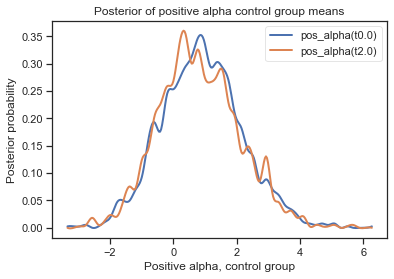

In [74]:
hddm.analyze.plot_posterior_nodes([pos_alpha_cnt_t0,  pos_alpha_cnt_t2])
plt.xlabel('Positive alpha, control group')
plt.ylabel('Posterior probability')
plt.title('Posterior of positive alpha control group means')

Text(0.5, 1.0, 'Posterior of positive alpha control group means')

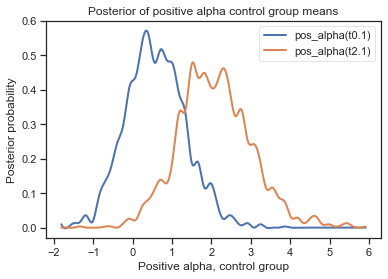

In [75]:
hddm.analyze.plot_posterior_nodes([pos_alpha_spe_t0,  pos_alpha_spe_t2])
plt.xlabel('Positive alpha, control group')
plt.ylabel('Posterior probability')
plt.title('Posterior of positive alpha control group means')

In [76]:
print("P(pos-alpha control t0 > pos-alpha control t2) = ", (pos_alpha_cnt_t0.trace() > pos_alpha_cnt_t2.trace()).mean())
print("P(pos-alpha treatment t0 > pos-alpha treatment t2) = ", (pos_alpha_spe_t0.trace() > pos_alpha_spe_t2.trace()).mean())

P(pos-alpha control t0 > pos-alpha control t2) =  0.528
P(pos-alpha treatment t0 > pos-alpha treatment t2) =  0.0895


In [77]:
print("P(pos-alpha control t0 > pos-alpha treatment t0) = ", (pos_alpha_cnt_t0.trace() > pos_alpha_spe_t0.trace()).mean())
print("P(pos-alpha control t2 > pos-alpha treatment t2) = ", (pos_alpha_cnt_t2.trace() > pos_alpha_spe_t2.trace()).mean())

P(pos-alpha control t0 > pos-alpha treatment t0) =  0.581
P(pos-alpha control t2 > pos-alpha treatment t2) =  0.211


## Negative alpha

Text(0.5, 1.0, 'Posterior of negative alpha control group means')

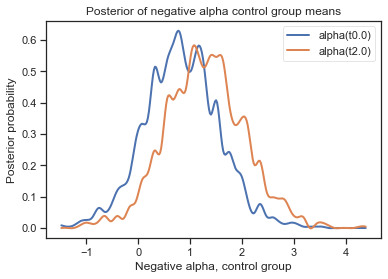

In [89]:
hddm.analyze.plot_posterior_nodes([neg_alpha_cnt_t0,  neg_alpha_cnt_t2])
plt.xlabel('Negative alpha, control group')
plt.ylabel('Posterior probability')
plt.title('Posterior of negative alpha control group means')

Text(0.5, 1.0, 'Posterior of negative alpha control group means')

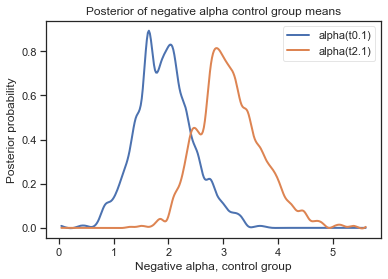

In [90]:
hddm.analyze.plot_posterior_nodes([neg_alpha_spe_t0,  neg_alpha_spe_t2])
plt.xlabel('Negative alpha, control group')
plt.ylabel('Posterior probability')
plt.title('Posterior of negative alpha control group means')

In [78]:
print("P(neg-alpha control t0 > neg-alpha control t2) = ", (neg_alpha_cnt_t0.trace() > neg_alpha_cnt_t2.trace()).mean())
print("P(neg-alpha treatment t0 > neg-alpha treatment t2) = ", (neg_alpha_spe_t0.trace() > neg_alpha_spe_t2.trace()).mean())

P(neg-alpha control t0 > neg-alpha control t2) =  0.315
P(neg-alpha treatment t0 > neg-alpha treatment t2) =  0.0625


In [79]:
print("P(neg-alpha control t0 > neg-alpha treatment t0) = ", (neg_alpha_cnt_t0.trace() > neg_alpha_spe_t0.trace()).mean())
print("P(neg-alpha control t2 > neg-alpha treatment t2) = ", (neg_alpha_cnt_t2.trace() > neg_alpha_spe_t2.trace()).mean())

P(neg-alpha control t0 > neg-alpha treatment t0) =  0.0935
P(neg-alpha control t2 > neg-alpha treatment t2) =  0.0175


## Drift rate

In [80]:
print("P(v control t0 > v control t2) = ", (v_cnt_t0.trace() > v_cnt_t2.trace()).mean())
print("P(v treatment t0 > v treatment t2) = ", (v_spe_t0.trace() > v_spe_t2.trace()).mean())

P(v control t0 > v control t2) =  0.6355
P(v treatment t0 > v treatment t2) =  0.7255


In [81]:
print("P(v control t0 > v treatment t0) = ", (v_cnt_t0.trace() > v_spe_t0.trace()).mean())
print("P(v control t2 > v treatment t2) = ", (v_cnt_t2.trace() > v_spe_t2.trace()).mean())

P(v control t0 > v treatment t0) =  0.8225
P(v control t2 > v treatment t2) =  0.8275


## Decision threshold

In [82]:
print("P(a control   t0 > a control t2) = ",   (a_cnt_t0.trace() > a_cnt_t2.trace()).mean())
print("P(a treatment t0 > a treatment t2) = ", (a_spe_t0.trace() > a_spe_t2.trace()).mean())

P(a control   t0 > a control t2) =  0.7545
P(a treatment t0 > a treatment t2) =  0.8185


In [83]:
print("P(a control t0 > a treatment t0) = ", (a_cnt_t0.trace() > a_spe_t0.trace()).mean())
print("P(a control t2 > a treatment t2) = ", (a_cnt_t2.trace() > a_spe_t2.trace()).mean())

P(a control t0 > a treatment t0) =  0.4865
P(a control t2 > a treatment t2) =  0.385


## Non decision time

In [84]:
print("P(t control   t0 > t control t2) = ",   (t_cnt_t0.trace() > t_cnt_t2.trace()).mean())
print("P(t treatment t0 > t treatment t2) = ", (t_spe_t0.trace() > t_spe_t2.trace()).mean())

P(t control   t0 > t control t2) =  0.6035
P(t treatment t0 > t treatment t2) =  0.6135


In [85]:
print("P(t control t0 > t treatment t0) = ", (t_cnt_t0.trace() > t_spe_t0.trace()).mean())
print("P(t control t2 > t treatment t2) = ", (t_cnt_t2.trace() > t_spe_t2.trace()).mean())

P(t control t0 > t treatment t0) =  0.3965
P(t control t2 > t treatment t2) =  0.347


In [86]:
traces = mod.get_traces()

Plotting alpha(t0.0)
Plotting alpha(t0.1)
Plotting alpha(t2.0)
Plotting alpha(t2.1)
Plotting pos_alpha(t0.0)
Plotting pos_alpha(t0.1)
Plotting pos_alpha(t2.0)
Plotting pos_alpha(t2.1)


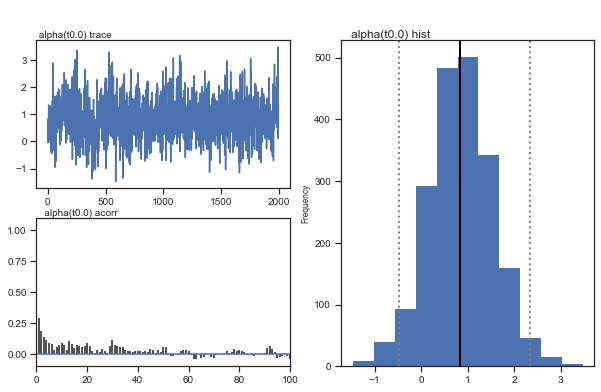

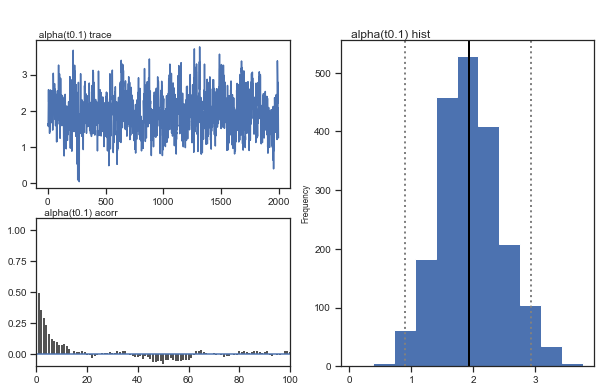

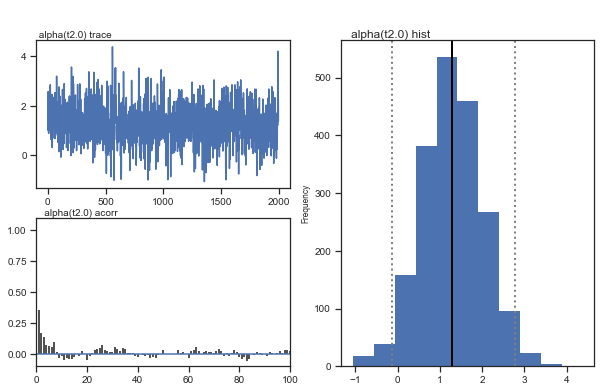

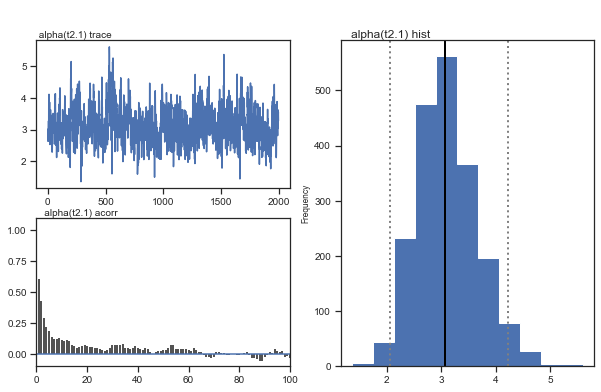

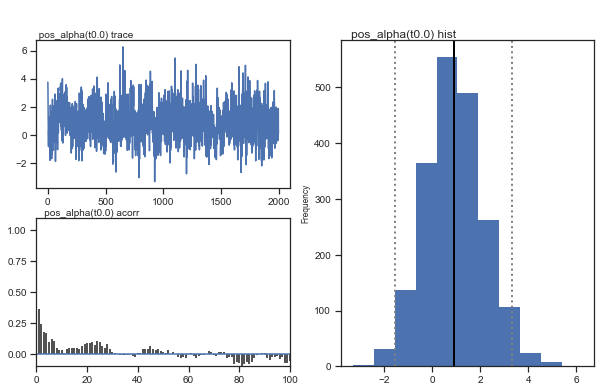

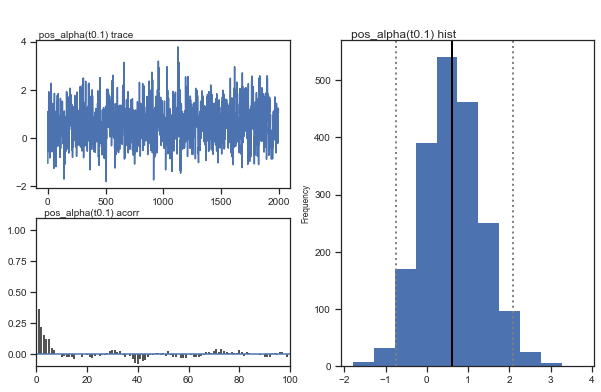

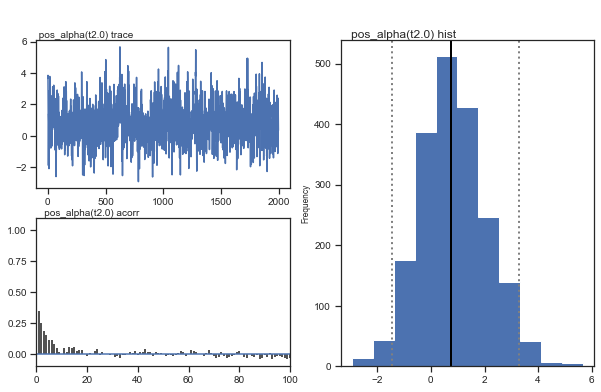

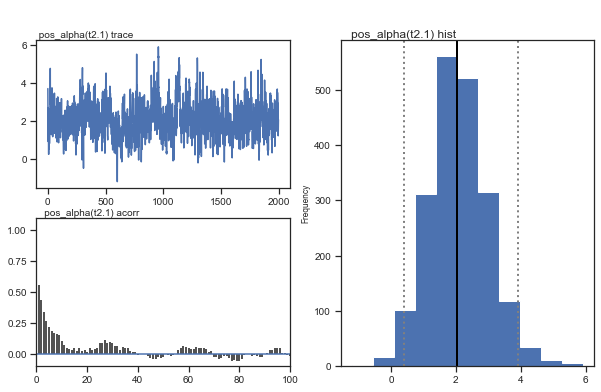

In [87]:
mod.plot_posteriors(['alpha', 'pos_alpha'])

In [88]:
mod.plot_posterior_predictive(figsize=(14, 10))

<Figure size 1008x720 with 0 Axes>

<Figure size 1008x720 with 0 Axes>

<Figure size 1008x720 with 0 Axes>

<Figure size 1008x720 with 0 Axes>